Map Lagrangian precipitation maximum onto MCS age

In [5]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from tqdm import tqdm

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt
import pickle

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'lifecycle_mapping', 'plot1D', 'plot2D', 'plotCondPDFs']
Own modules available: ['PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_load_RCEMIP_SAM', 'fcns_movie', 'fcns_multiscale_extremes', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_DYAMOND_SAM_Tb_Feng', 'load_TOOCAN_v208_DYAMOND']


In [4]:
%autoreload 2

# to access segmentation files and simulation outputs
from fcns_load_DYAMOND_SAM import *
# to access TOOCAN objects
# from load_TOOCAN_DYAMOND_modif_BF import *
from load_TOOCAN_v208_DYAMOND import *
# mapping function
from lifecycle_mapping import *
# display functions
from fcns_movie import *
# plotting
from plot1D import *
# load own libraries
from conditionalstats import *

In [6]:
# load relation table
relation_table = loadRelTable('DYAMOND_SEG')

In [7]:
glob.glob(os.path.join(DIR_TOOCAN_DYAMOND,'*.gz'))

['/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz',
 '/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz']

In [47]:
toocan = loadAllMCSs(DIR_TOOCAN_DYAMOND,load_TOOCAN_DYAMOND)

load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz
load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz


In [ ]:
# list of TOOCAN labels, for quicker mapping on toocan list
labels_toocan = [toocan[i].label for i in range(len(toocan))]

In [ ]:
len(labels_toocan)

In [48]:
toocan[0]

< MCS_IntParameters object:
 . DCS_number: 1
 . INT_qltyDCS: 11101
 . INT_classif: 2
 . INT_duration: 34.5
 . INT_UTC_timeInit: 1470029400
 . INT_localtime_Init: 1470057360
 . INT_lonInit: 116.46
 . INT_latInit: 21.32
 . INT_UTC_timeEnd: 1470151800
 . INT_localtime_End: 1470178440
 . INT_lonEnd: 111.0
 . INT_latEnd: 20.28
 . INT_velocityAvg: 4.66
 . INT_distance: 578.95
 . INT_lonmin: 110.94
 . INT_latmin: 20.24
 . INT_lonmax: 116.86
 . INT_latmax: 22.83
 . INT_TbMin: 188.0
 . INT_surfmaxPix_235K: 0
 . INT_surfmaxkm2_235K: 377157.25
 . INT_surfmaxkm2_220K: 333978.47
 . INT_surfmaxkm2_210K: 308290.25
 . INT_surfmaxkm2_200K: 255521.17
 . INT_surfcumkm2_235K: 12840728.0
 . INT_classif_JIRAK: 0.0
 . INT_classif_MADDOX: 0.0
 . clusters: <class 'load_TOOCAN_v208_DYAMOND.MCS_Lifecycle'>
 >

# adapt load DYAMOND

In [45]:
date_key = '-0'.join(relation_table['img_seg_path'][0].split('_')[-1].split('-'))
year = date_key[:4]
month = date_key[4:6]
day = date_key[6:8]
filename = 'mcs_mask_TOOCAN_SAM_'+date_key
full_path = os.path.join(DIR_TOOCANSEG_DYAMOND,'%s_%s_%s'%(year,month,day),filename)
full_path

'/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/2016_08_01/mcs_mask_TOOCAN_SAM_20160801-003.nc'

In [46]:
! ls /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/2016_08_01/mcs_mask_TOOCAN_SAM_20160801-003.nc

/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/2016_08_01/mcs_mask_TOOCAN_SAM_20160801-003.nc


In [47]:
path_TOOCAN = full_path

In [53]:
img_TOOCAN = xr.open_dataset(path_TOOCAN).mcs_mask
img_TOOCAN

/home/bfildier/.local/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'cloud_mask' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/bfildier/.local/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'mcs_mask' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.DataArray 'mcs_mask' (time: 1, latitude: 2072, longitude: 9216)>
[19095552 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -40.0 -39.96 -39.92 ... 39.92 39.96 40.0
  * longitude  (longitude) float32 0.01953 0.05859 0.09766 ... 359.9 359.9 360.0
  * time       (time) datetime64[ns] 2016-08-01T01:00:00
Attributes:
    units:           
    standard_name:  TOOCAN_mcs_masks
    long_name:      MCS mask with track number

In [54]:
img_TOOCAN_v207 = loadTOOCANSeg(1,relation_table,toocan_version='v2.07',keep_path=True)

/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/2016_08_01/ImageSegTOOCAN_20160801-04.nc


In [55]:
img_TOOCAN_v207

<xarray.DataArray 'MCS_label' (time: 1, latitude: 2072, longitude: 9216)>
[19095552 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -40.0 -39.96 -39.92 ... 39.92 39.96 40.0
  * longitude  (longitude) float32 0.01953 0.05859 0.09766 ... 359.9 359.9 360.0
  * time       (time) datetime64[ns] 2016-08-01T01:30:00
Attributes:
    units:           
    standard_name:  MCS_label
    long_name:      MCS labellisation

In [56]:
img_TOOCAN_v208 = loadTOOCANSeg(1,relation_table)

In [59]:
img_TOOCAN_v208

<xarray.DataArray 'mcs_mask' (time: 1, latitude: 2072, longitude: 9216)>
[19095552 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -40.0 -39.96 -39.92 ... 39.92 39.96 40.0
  * longitude  (longitude) float32 0.01953 0.05859 0.09766 ... 359.9 359.9 360.0
  * time       (time) datetime64[ns] 2016-08-01T01:00:00
Attributes:
    units:           
    standard_name:  TOOCAN_mcs_masks
    long_name:      MCS mask with track number

In [13]:
! ls /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/

2016_08_01  2016_08_10	2016_08_19  2016_08_28	2016_09_06
2016_08_02  2016_08_11	2016_08_20  2016_08_29	2016_09_07
2016_08_03  2016_08_12	2016_08_21  2016_08_30	2016_09_08
2016_08_04  2016_08_13	2016_08_22  2016_08_31	2016_09_09
2016_08_05  2016_08_14	2016_08_23  2016_09_01	2016_09_10
2016_08_06  2016_08_15	2016_08_24  2016_09_02	FileTracking
2016_08_07  2016_08_16	2016_08_25  2016_09_03	FileTracking_NETCDF
2016_08_08  2016_08_17	2016_08_26  2016_09_04	param_runSAM_235K_test.dat
2016_08_09  2016_08_18	2016_08_27  2016_09_05


GOAL: draw composite of maximum precipitation as a function of MCS lifecycle

# Lifecycle mapping object

In [15]:
def loadTOOCANTimeTable():
    
    # set location on disk and check if exists
    timetable_file = 'TOOCAN_time_table.csv'
    timetable_path = os.path.join(DIR_DATA,timetable_file)

    # check if table exists on disk
    table_exists = len(glob.glob(timetable_path)) > 0 

    # choose to overwrite
    overwrite = False

    # Load or compute time table

    if table_exists and not overwrite:

        #-- read from disk
        print('reading from %s'%timetable_path)
        toocan_timetable = pd.read_csv(timetable_path)

    else:

         toocan_timetable = None
            
    return toocan_timetable

In [16]:
def initLifeCycleMappingObject():
    
    #-- prerequisites to LCM object
    
    # load relation table
    relation_table = loadRelTable('DYAMOND_SEG')
    
    # load TOOCAN (.gz version)
    toocan = loadAllMCSs(DIR_TOOCAN_DYAMOND,load_TOOCAN_DYAMOND)
    
    # list of TOOCAN labels, for quicker mapping on toocan list
    labels_toocan = [toocan[i].label for i in range(len(toocan))]
    
    # load TOOCAN timetable
    toocan_timetable = loadTOOCANTimeTable()
    
    #-- initialize LCM object
    lcm = LifeCycleMapping(relation_table,toocan_timetable,toocan,timestep)
    
    # compute mapping label to index for faster fetching of MCS in toocan list by label
    lcm.defineMappingLabelToIndex()
    
    # compute unique labels
    lcm.findValidLabels()
    
    return lcm

In [21]:
out_dir = os.path.join(DIR_OUT,region,'life_cycle_mapping')

# model timestep
timestep = 0.5

In [22]:
#- define LifeCycleMappingObject

lcm_obj_name = 'lcm.pickle'
lcm_path = os.path.join(out_dir,'lcm.pickle')

if len(glob.glob(lcm_path)) > 0: # then already exists

    # load
    lcm = pickle.load(open(lcm_path,'rb'))

else:

    # initialize
    lcm = initLifeCycleMappingObject()

    # save
    pickle.dump(lcm,open(lcm_path,'wb'))

In [17]:
print('size of lcm object:',sys.getsizeof(lcm))
print('size of relation_table object:',sys.getsizeof(lcm.relation_table))

size of lcm object: 48
size of relation_table object: 805196


In [ ]:
from pympler import asizeof
print('size of lcm object:',asizeof.asizeof(lcm))
print('size of relation_table object:',asizeof.asizeof(lcm.relation_table))

# Define output xarray

In [19]:
#-- time coordinate for storing the lifecycle values
N_ages = 96
age = np.arange(N_ages)*lcm.timestep # in hours

N_labels = len(lcm.labels_toocan)

In [20]:
N_labels, N_ages

(347106, 96)

In [21]:
#- define label coordinate
label_toocan = lcm.labels_toocan.copy()
# mask for valid labels
mask_labels_valid = np.in1d(label_toocan,lcm.labels_valid)

In [23]:
# Initialize dataset with pre-computed MCS characteristics

ds = xr.Dataset(
    data_vars=dict(
        valid_flag=(["MCS_label"],mask_labels_valid),
        area=(["MCS_label", "age"], np.full((N_labels,N_ages),np.nan)),
        time_birth=(["MCS_label"], np.full((N_labels),np.nan,dtype=np.datetime64)),
        time_death=(["MCS_label"], np.full((N_labels),np.nan,dtype=np.datetime64)),
        duration=(["MCS_label"],  np.full((N_labels),np.nan)),
        prec_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
        longitude_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
        latitude_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
        land_mask=(["MCS_label", "age"], np.full((N_labels,N_ages),np.nan)),
    ),
    coords=dict(
        MCS_label=label_toocan, # MCS label, removing duplicates
        age=age,#'hours from time_birth'), # time from MCS birth
    ),
    attrs=dict(description="Lagrangian MCS data"),
)

# attributes
ds['valid_flag'].attrs['description'] = 'True if MCS label is valid, False if duplicate'
ds['area'].attrs['description'] = 'area in km2 from 172W/m2 threshold in TOOCAN'
# ds['time_birth'].attrs['units'] = "hours since 2000-01-01"
ds['MCS_label'].attrs['description'] = 'TOOCAN labels for non-duplicate MCS labels only'
ds['MCS_label'].attrs['units'] = 'None'
ds['age'].attrs['description'] = 'age coordinate for anvil lifecycle'
ds['age'].attrs['units'] = 'hours from time of birth'

In [24]:
ds

<xarray.Dataset>
Dimensions:        (MCS_label: 347106, age: 96)
Coordinates:
  * MCS_label      (MCS_label) int64 287370 287371 287372 ... 296301 296327
  * age            (age) float64 0.0 0.5 1.0 1.5 2.0 ... 46.0 46.5 47.0 47.5
Data variables:
    valid_flag     (MCS_label) bool True True True True ... True True True True
    area           (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    time_birth     (MCS_label) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    time_death     (MCS_label) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    duration       (MCS_label) float64 nan nan nan nan nan ... nan nan nan nan
    prec_max       (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    longitude_max  (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    latitude_max   (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    land_mask      (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Lagrangian MCS data

In [25]:
#-- define time axis 
#-- as datetimes between 2016-8-1-1-30 and 2016-9-10-0-0 by 30mn increments

# indices of time bounds
i_min = 0
i_max = 1917
# define start time
time_min = relation_table.iloc[i_min].str_code
dt_min = dt.datetime.strptime(time_min,"%Y-%m-%d-%H-%M")
# define 30mn increment
dt_delta = dt.timedelta(seconds = 30*60)
# create time array
time_simulation = np.array([np.datetime64(dt_min+i*dt_delta) for i in range(i_min,i_max+1)])
print(time_simulation)

['2016-08-01T01:30:00.000000' '2016-08-01T02:00:00.000000'
 '2016-08-01T02:30:00.000000' ... '2016-09-09T23:00:00.000000'
 '2016-09-09T23:30:00.000000' '2016-09-10T00:00:00.000000']


In [26]:
#-- retain only unique MCS labels NB : ALREADY IN LifeCycleMapping OBJECT

labels_unique, labels_counts = np.unique(labels_toocan,return_counts=True)
# appear several times
ind_several = np.where(labels_counts > 1)[0]
labels_several = [labels_unique[i] for i in ind_several]
# appear only once
ind_unique = np.where(labels_counts == 1)[0]
labels_valid = [labels_unique[i] for i in ind_unique]

n_labels = len(labels_toocan)
n_labels_u = len(labels_unique)
n_labels_s = len(labels_several)

print("labels appearing several times (to remove):")
print(" ",labels_several)
print()
print('#(labels) =',n_labels)
print('#(labels_unique) =',n_labels_u)
print('#(labels_several) =',n_labels_s)

labels appearing several times (to remove):
  [717, 729, 2565, 2903, 3327, 5728, 18298, 18537, 18539, 19218, 20562, 20565, 21368, 23984, 24391, 25621, 26139, 28061, 31542, 33523, 33524, 41189, 43066, 49149, 49717, 52429, 53092, 55540, 62755, 63769, 64271, 64272, 64569, 64570, 64807, 65055, 66285, 67801, 68454, 72417, 74141, 87444, 87445, 87662, 104757, 105566, 113595, 125606, 128417, 141662, 150634, 153266, 156107, 156370, 162780, 171631, 174849, 175108, 180755, 181941, 190433, 192691, 194926, 196100, 199485, 207567, 207965, 218615, 219796, 221569, 224652, 224705, 229157, 229318, 230911, 231223, 239805, 252646, 257068, 258692, 258911, 259047, 260964, 266678, 267866, 267867, 268595, 268660, 276058, 277656, 278325, 280233, 281159, 285952, 287751, 289761, 290318, 297070, 298033, 298073, 298074, 298823, 299352, 299380, 313110, 315861, 318489, 318490, 319169, 319753, 325514, 327698, 328137, 328138, 329491, 331575, 331576, 331627, 343880, 346428, 350434, 352908, 354173, 354445, 355507, 35622

In [27]:
#-- extract birth and deaths

def Utime2Datetime(Utime):
    
    days = int(str(Utime).split('.')[0])
    n_steps = int(str(Utime).split('.')[1])
    
    date = np.datetime64(dt.datetime(1970,1,1) + dt.timedelta(seconds=days*86400+n_steps*30*60))
    
    return date

def formatLifecycleData(TOOCAN_attr):
    
    # get values
    var_list = [getattr(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].clusters,TOOCAN_attr) for i in range(len(lcm.labels_valid))]
    # get length
    v_length = max(len(v) for v in var_list)
    # pad the different sizes of lists with nans
    var = np.vstack([v + [np.nan] * (max(N_ages,v_length) - len(v)) for v in var_list])
    
    return var

#- birth times
time_birth = np.array([Utime2Datetime(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].Utime_Init) for i in range(len(lcm.labels_valid))])

#- death times
time_death = np.array([Utime2Datetime(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].Utime_End) for i in range(len(lcm.labels_valid))])

#- durations
duration = np.array([lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].duration for i in range(len(lcm.labels_valid))])

#- areas
# area_list = [lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].clusters.surfkm2_172Wm2 for i in range(len(lcm.labels_valid))]
# # pad the different sizes of lists with nans
# max_a_length = max(len(a) for a in area_list)
# # area = np.vstack([a + [np.nan] * (max_a_length - len(a)) for a in area_list])
# area = np.vstack([a + [np.nan] * (max(N_ages,max_a_length) - len(a)) for a in area_list])

area = formatLifecycleData('surfkm2_172Wm2')

In [28]:
#- store in xarray

for key in ['time_birth','time_death','duration','area']:
    
    ds[key][ds['valid_flag']] = getattr(thismodule,key)

In [29]:
ds

<xarray.Dataset>
Dimensions:        (MCS_label: 347106, age: 96)
Coordinates:
  * MCS_label      (MCS_label) int64 287370 287371 287372 ... 296301 296327
  * age            (age) float64 0.0 0.5 1.0 1.5 2.0 ... 46.0 46.5 47.0 47.5
Data variables:
    valid_flag     (MCS_label) bool True True True True ... True True True True
    area           (MCS_label, age) float64 288.0 1.44e+03 3.52e+03 ... nan nan
    time_birth     (MCS_label) datetime64[ns] 2016-08-01T09:00:00 ... 2016-09...
    time_death     (MCS_label) datetime64[ns] 2016-08-01T21:00:00 ... 2016-09...
    duration       (MCS_label) float64 12.5 16.0 38.0 10.5 ... 1.5 1.5 1.5 1.5
    prec_max       (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    longitude_max  (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    latitude_max   (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    land_mask      (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Lagrangian MCS data

In [54]:
#-- Or: use the triangle fit of the cloud shield lifecycle in order to retrieve *adjusted* birth and death dates



# Extract maximum precipitation from each mask(MCS_label,t)

In [30]:
lon_slice = slice(0,360)
lat_slice = slice(-30,30)

In [31]:
#-- Initialize array
prec_max = np.full((N_labels,N_ages),np.nan)

In [32]:
# Load example data @ t

i_t = 17 # index in relation table
date = relation_table.loc[i_t].str_code

# load segmentation mask for that date
segmask = np.squeeze(loadTOOCANSeg(i_t,relation_table)).sel(latitude=lat_slice).data

# load precipitation data
prec_data = loadPrec(i_t,relation_table).sel(lat=lat_slice)
prec = prec_data.data

# coordinates
longitude_2D,latitude_2D = getCoords2D(prec_data,lon_slice,lat_slice)
del prec_data

# compute all MCS ages (2D)
MCS_age = lcm.computeAgesFromSegMask(i_t,segmask,metric='age')

In [184]:
# # get labels
# labels_t = lcm.getLabelsInSegMask(segmask)

# age indices (2D)
# i_age_t = pd.array(MCS_age.flatten()/lcm.timestep,dtype="Int64")
i_age_t = pd.array(MCS_age.flatten()/lcm.timestep,dtype="Int64")

In [185]:
##-- extract maximum precipitation in mask at time t (spatial maximum), 
#    using only matrix manipulations and reordering, for better efficiency

# Create a DataFrame
df = pd.DataFrame({'label': pd.array(segmask.flatten(),dtype="Int64"),
        'i_age': i_age_t,
        'prec': prec.flatten(),
        'longitude': longitude_2D.flatten(),
        'latitude': latitude_2D.flatten(),
        })

#- remove nan labels
df_clean = df.dropna()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # replace all negative precip by zeros
    df_clean['prec'][df_clean['prec'] < 0 ] = 0

# order array wrt. precip
df_ordered_prec = df_clean.sort_values(by=['label','prec'])

# find indices of last occurrence of each label
df_ordered_prec['label_diff'] = np.concatenate([np.diff(df_ordered_prec['label']),[1]])

# retain only the rows with max precip values (last in ordered values)
df_prec_max_label = df_ordered_prec[df_ordered_prec['label_diff'] > 0]

# reorder array wrt. label (so that, when extracting indices of labels, corresponding prec values are not swapped)
df_prec_max_label_ordered = df_prec_max_label.sort_values(by='label')

# remove rows with wrong ages ; these labels do not correctly appear in TOOCAN object
k_issue = np.where(df_prec_max_label_ordered['i_age'] < 0)[0]
df_prec_max_label_ordered.drop([df_prec_max_label_ordered.index[k] for k in k_issue],inplace = True)

# fix type changes, floats --> int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # make some values integers
    df_prec_max_label_ordered['label'] = df_prec_max_label_ordered['label'].astype(int)
    df_prec_max_label_ordered['i_age'] = df_prec_max_label_ordered['i_age'].astype(int)

In [186]:
#- compute indices of ordered valid labels (where to assign prec_max) in labels_valid

a = lcm.labels_toocan
b = df_prec_max_label_ordered['label'].values

# get indices of labels at t
ind_lab_t = np.argwhere(np.isin(a, b))[:,0]

# get indices of ages at t
ind_age_t = np.array(df_prec_max_label_ordered['i_age'].values)

#- assign in output xarray
for key in 'prec','longitude','latitude':
    
    ds['%s_max'%key][ind_lab_t,ind_age_t] = df_prec_max_label_ordered[key]


In [ ]:
## script exploration done. Now ready for automating in python script and send the job.

In [125]:
ds['MCS_label'].loc[i_lab_ex]

<xarray.DataArray 'MCS_label' ()>
array(70927)
Coordinates:
    MCS_label  int64 70927
Attributes:
    description:  TOOCAN labels for non-duplicate MCS labels only
    units:        None

In [128]:
##-- Sanity check on example

# example 
i_lab_ex = ind_lab_t[0]
i_age_ex = df_prec_max_label_ordered['i_age'].values[0]
print(i_lab_ex,i_age_ex,a[i_lab_ex])

for key in 'prec','longitude','latitude':
    print(key, ds['%s_max'%key].values[i_lab_ex,i_age_ex])

70927 2 1
prec 0.1682368665933609
longitude 232.59765625
latitude -19.95160675048828


In [122]:
# Sanity check on example

print(df_prec_max_label_ordered.loc[df_prec_max_label_ordered['label'] == 1])

          label  i_age       prec   longitude  latitude label_diff
12195701      1      2  49.589684  114.589828  21.11046          2


In [215]:
# for i in range(len(df_prec_max_label)): # TOO LOONG : find way to assign a matrix to the destination array
    
#     if i%100 == 0:
#         print(i,end='..')
    
#     row = df_prec_max_label.iloc[i]
#     label = row['label']
    
#     if label in lcm.labels_valid:
        
#         #- store
#         # find position
#         i_lab = np.where(lcm.labels_valid == label)[0][0]
#         # write
#         prec_max[i_lab,int(row['i_age'])] = row['prec']
    

Time boundaries in script?

In [39]:
len(relation_table)

1919

In [41]:
relation_table.iloc[0]

Unnamed: 0                                                      476
Unnamed: 0.4                                                  476.0
Unnamed: 0.3                                                  476.0
Unnamed: 0.2                                                  476.0
img_seg_path      data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...
str_code                                              2016-8-1-1-30
Unnamed: 0.1                                                    2.0
Unnamed: 0.1.1                                                  2.0
year                                                         2016.0
month                                                           8.0
day                                                             1.0
hour                                                            1.0
minute                                                         30.0
path_dyamond          DYAMOND_9216x4608x74_7.5s_4km_4608_0000000720
UTC                                             

In [44]:
relation_table.iloc[1917]

Unnamed: 0                                                     1304
Unnamed: 0.4                                                 1304.0
Unnamed: 0.3                                                 1304.0
Unnamed: 0.2                                                 1304.0
img_seg_path      data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...
str_code                                              2016-9-10-0-0
Unnamed: 0.1                                                 1919.0
Unnamed: 0.1.1                                               1919.0
year                                                         2016.0
month                                                           9.0
day                                                            10.0
hour                                                            0.0
minute                                                          0.0
path_dyamond          DYAMOND_9216x4608x74_7.5s_4km_4608_0000460800
UTC                                             

# DEBUG python script -- 2024-02-08

In [33]:
##-- functions for output setup

def loadTOOCANTimeTable():
    
    # set location on disk and check if exists
    timetable_file = 'TOOCAN_time_table.csv'
    timetable_path = os.path.join(DIR_DATA,timetable_file)

    # check if table exists on disk
    table_exists = len(glob.glob(timetable_path)) > 0 

    # choose to overwrite
    overwrite = False

    # Load or compute time table

    if table_exists and not overwrite:

        #-- read from disk
        print('reading from %s'%timetable_path)
        toocan_timetable = pd.read_csv(timetable_path)

    else:

         toocan_timetable = None
            
    return toocan_timetable

def initLifeCycleMappingObject():
    
    #-- prerequisites to LCM object
    
    # load relation table
    relation_table = loadRelTable('DYAMOND_SEG')
    
    # load TOOCAN (.gz version)
    toocan = loadAllMCSs(DIR_TOOCAN_DYAMOND,load_TOOCAN_DYAMOND)
    
    # list of TOOCAN labels, for quicker mapping on toocan list
    labels_toocan = [toocan[i].label for i in range(len(toocan))]
    
    # load TOOCAN timetable
    toocan_timetable = loadTOOCANTimeTable()
    
    #-- initialize LCM object
    lcm = LifeCycleMapping(relation_table,toocan_timetable,toocan,timestep)
    
    # compute mapping label to index for faster fetching of MCS in toocan list by label
    lcm.defineMappingLabelToIndex()
    
    # compute unique labels
    lcm.findValidLabels()
    
    return lcm


def initOutputArray(label_toocan,age):
    """Initialize output xarray 'ds' containing relevant fields.
    Transfer relevant TOOCAN data.
    
    Returns:
    """

    N_labels = len(label_toocan)
    N_ages = len(age)
    
    # Initialize dataset with pre-computed MCS characteristics

    ds = xr.Dataset(
        data_vars=dict(
            valid_flag=(["MCS_label"],np.full((N_labels),np.nan)),
            area=(["MCS_label", "age"], np.full((N_labels,N_ages),np.nan)),
            time_birth=(["MCS_label"], np.full((N_labels),np.nan,dtype=np.datetime64)),
            time_death=(["MCS_label"], np.full((N_labels),np.nan,dtype=np.datetime64)),
            duration=(["MCS_label"],  np.full((N_labels),np.nan)),
            prec_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
            longitude_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
            latitude_max=(["MCS_label", "age"],  np.full((N_labels,N_ages),np.nan)),
            land_mask=(["MCS_label", "age"], np.full((N_labels,N_ages),np.nan)),
        ),
        coords=dict(
            MCS_label=label_toocan, # MCS label, removing duplicates
            age=age,#'hours from time_birth'), # time from MCS birth
        ),
        attrs=dict(description="Lagrangian MCS data"),
    )

    # attributes
    ds['valid_flag'].attrs['description'] = 'True if MCS label is valid, False if duplicate'
    ds['area'].attrs['description'] = 'area in km2 from 172W/m2 threshold in TOOCAN'
    # ds['time_birth'].attrs['units'] = "hours since 2000-01-01"
    ds['MCS_label'].attrs['description'] = 'TOOCAN labels for non-duplicate MCS labels only'
    ds['MCS_label'].attrs['units'] = 'None'
    ds['age'].attrs['description'] = 'age coordinate for anvil lifecycle'
    ds['age'].attrs['units'] = 'hours from time of birth'

    return ds

def fillWithTrackingData(ds):
    """Fill output array with relevant lifecycle data retrieved during tracking.
    
    Arguments:
    - mask_labels_valid: mask of valid MCS labels (not duplicates)
    - 
    """

    # mask for valid labels
    ds['valid_flag'].values = np.in1d(label_toocan,lcm.labels_valid)

    #-- then, only where labels are valid:
    # birth times
    ds['time_birth'][ds['valid_flag']] = np.array([Utime2Datetime(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].Utime_Init) for i in range(len(lcm.labels_valid))])

    # death times
    ds['time_death'][ds['valid_flag']] = np.array([Utime2Datetime(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].Utime_End) for i in range(len(lcm.labels_valid))])

    # durations
    ds['duration'][ds['valid_flag']] = np.array([lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].duration for i in range(len(lcm.labels_valid))])

    # areas
    ds['area'][ds['valid_flag']] = formatLifecycleData('surfkm2_172Wm2')
    
    

def Utime2Datetime(Utime):
    """Convert Utime (as in TOOCAN objects) into datetime.datetime objects"""
    
    days = int(str(Utime).split('.')[0])
    n_steps = int(str(Utime).split('.')[1])
    
    date = np.datetime64(dt.datetime(1970,1,1) + dt.timedelta(seconds=days*86400+n_steps*30*60))
    
    return date

def formatLifecycleData(TOOCAN_attr):
    """Convert variables stored along lifecycle in TOOCAN and format them as matrix to feed in output file"""
    
    # get values
    var_list = [getattr(lcm.toocan[lcm.toocan_index_of_label[lcm.labels_valid[i]]].clusters,TOOCAN_attr) for i in range(len(lcm.labels_valid))]
    # get length
    v_length = max(len(v) for v in var_list)
    # pad the different sizes of lists with nans
    var = np.vstack([v + [np.nan] * (max(N_ages,v_length) - len(v)) for v in var_list])
    
    return var
    
    
##-- Functions for time iteration
    
def loadDataAtSlice(i_t,lcm,lon_slice,lat_slice):
    """Load relevant fields : TOOCAN segmentation mask, precipitation values"""
    
    # date
    date = lcm.relation_table.loc[i_t].str_code

    # load segmentation mask for that date
    segmask = np.squeeze(loadTOOCANSeg(i_t,lcm.relation_table)).sel(latitude=lat_slice).data

    # load precipitation data
    prec_data = loadPrec(i_t,lcm.relation_table).sel(lat=lat_slice)
    prec = prec_data.data

    # coordinates
    longitude_2D,latitude_2D = getCoords2D(prec_data,lon_slice,lat_slice)
    del prec_data

    # compute all MCS ages (2D)
    MCS_age = lcm.computeAgesFromSegMask(i_t,segmask,metric='age')
    
    # age indices (2D)
    i_age_t = np.asarray(MCS_age/lcm.timestep,dtype=int)
    del MCS_age
    
    return date, segmask, prec, longitude_2D, latitude_2D, i_age_t


def computeMaxVarAtSlice(var,varid,segmask, longitude_2D, latitude_2D, i_age_t, i_t): 
    # Works similarly as following function, but is slower. Does it use less memory?
    """Compute the maximum value and its coordinates within each MCS label.
    
    Arguments:
    - var: variable,
    - varid: variable name.
    
    Returns:
    - df_var_max: dataframe of label-wise maximum variable values and coordinates
    """
    
    # Create a DataFrame
    df = pd.DataFrame({'label': segmask.flatten(),
            'i_age': i_age_t.flatten(),
            varid: var.flatten(),
            'longitude': longitude_2D.flatten(),
            'latitude': latitude_2D.flatten(),
            })
    
    #- remove nan labels
    df_clean = df.dropna()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # replace all negative precip by zeros
        df_clean[varid][df_clean[varid] < 0 ] = 0
    
    #- iterate over labels and store max value
    all_labels = np.unique(df_clean.label)
    all_labels = np.array(all_labels[~np.isnan(all_labels)],dtype=int)

    df_list = []

    for label in tqdm(all_labels):

        # (sub)frame at label
        df_ilab = df_clean.loc[df_clean.label==label]
        # extract max var
        var_max = np.max(df_ilab[varid])
        # save line of max
        df_list.append(df_ilab.loc[df_ilab[varid]==var_max])
        
    df_var_max = pd.concat(df_list)
    
    # remove duplicate labels
    df_var_max = df_var_max.drop_duplicates(keep='first',subset='label')

    # add current time index as attribute
    # df_var_max.i_t = i_t
    df_var_max.attrs['i_t'] = i_t
    
    return df_var_max
    
    
def computeMaxPrecAtSlice(i_t):
    """Compute the maximum precipitation and its coordinates within each MCS label.
    
    Arguments:
    - i_t: time index
    
    Returns:
    - df_prec_max_label_ordered: pandas dataframe, with labels of MCS at t, prec_max, coordinates
    """
    
    ##-- extract maximum precipitation in mask at time t (spatial maximum), 
    #    using only matrix manipulations and reordering, for better efficiency

    # Create a DataFrame
    df = pd.DataFrame({'label': segmask.flatten(),
            'i_age': i_age_t.flatten(),
            'prec': prec.flatten(),
            'longitude': longitude_2D.flatten(),
            'latitude': latitude_2D.flatten(),
            })

    #- remove nan labels
    df_clean = df.dropna()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # replace all negative precip by zeros
        df_clean['prec'][df_clean['prec'] < 0 ] = 0

    # order array wrt. precip
    df_ordered_prec = df_clean.sort_values(by=['label','prec'])

    # find indices of last occurrence of each label
    df_ordered_prec['label_diff'] = np.concatenate([np.diff(df_ordered_prec['label']),[1]])

    # retain only the rows with max precip values (last in ordered values)
    df_prec_max_label = df_ordered_prec[df_ordered_prec['label_diff'] > 0]

    # reorder array wrt. label (so that, when extracting indices of labels, corresponding prec values are not swapped)
    df_prec_max_label_ordered = df_prec_max_label.sort_values(by='label')
    
    # remove rows with wrong ages ; these labels do not correctly appear in TOOCAN object
    k_issue = np.where(df_prec_max_label_ordered['i_age'] < 0)[0]
    df_prec_max_label_ordered.drop([df_prec_max_label_ordered.index[k] for k in k_issue],inplace = True)

    # fix type changes, floats --> int
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # make some values integers
        df_prec_max_label_ordered['label'] = df_prec_max_label_ordered['label'].astype(int)
        df_prec_max_label_ordered['i_age'] = df_prec_max_label_ordered['i_age'].astype(int)
    
    return df_prec_max_label_ordered
    
    
def assignVarMaxToOutput(ds,varnames,lcm,df):
    
    #- compute indices of ordered valid labels (where to assign prec_max) in labels_valid

    a = lcm.labels_toocan
    b = df['label'].values

    # show labels that are in df_max but not in lcm.labels_toocan
    ind_intruders = np.where(~np.isin(b,a))[0]
    label_intruders = b[ind_intruders] # just out of curiosity
    if len(label_intruders) > 0:
        print('intruder labels (present in df but not in TOOCAN object):',label_intruders)

    # ignore intruder labels (not found in b)
    ind_common = np.where(np.isin(b,a))[0]
    b = b[ind_common]
    df = df.iloc[ind_common]
    
    # get indices of labels at t
    ind_lab_t = np.argwhere(np.isin(a, b))[:,0]

    # get indices of ages at t
    ind_age_t = df['i_age'].values
    
    # create coordinates
    coords = np.vstack([ind_lab_t,ind_age_t])
    assert len(a) == ds['prec_max'].shape[0], "number of labels differ"
    flat_indices = np.ravel_multi_index(coords, ds['prec_max'].shape)

#     #- assign in output xarray
#     for key in varnames:

#         ds['%s_max'%key][ind_lab_t,ind_age_t] = df[key]

    #- assign in output xarray
    for key in varnames:
        
        try:
            
            # ds['%s_max'%key][ind_lab_t,ind_age_t] = df[key]
            np.put(ds['%s_max'%key].values,flat_indices,df[key])
            
        except IndexError:
            print('IndexError ! ')
            print('occured during assignment assignVarMaxToOutput, for rel_table time index %d'%(df.i_t))
            print('for key %s'%(key))
            print('ind_lab_t :')
            print(ind_lab_t)
            print('ind_age_t:')
            print(ind_age_t)
        

In [42]:
#-- arguments
# i_t0 = 1
i_t0 = 1855
Ni = 10
region = 'tropics'
N_ages = 96
timestep = 0.5

# geographical parameters
if region == 'tropics':
    lon_slice = slice(0,360)
    lat_slice = slice(-30,30)

#- define LifeCycleMappingObject
lcm = initLifeCycleMappingObject()

#- define coordinates
# define label coordinate
label_toocan = lcm.labels_toocan
# define age
age = np.arange(N_ages)*lcm.timestep # in hours

#- Initalize output
ds = initOutputArray(label_toocan,age)

#- Fill output array with toocan characteristics
fillWithTrackingData(ds)


load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz
load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz


AttributeError: 'MCS_IntParameters' object has no attribute 'label'

In [43]:
toocan[0]

NameError: name 'toocan' is not defined

In [41]:
ds

<xarray.Dataset>
Dimensions:        (MCS_label: 347106, age: 96)
Coordinates:
  * MCS_label      (MCS_label) int64 287370 287371 287372 ... 296301 296327
  * age            (age) float64 0.0 0.5 1.0 1.5 2.0 ... 46.0 46.5 47.0 47.5
Data variables:
    valid_flag     (MCS_label) bool True True True True ... True True True True
    area           (MCS_label, age) float64 288.0 1.44e+03 3.52e+03 ... nan nan
    time_birth     (MCS_label) datetime64[ns] 2016-08-01T09:00:00 ... 2016-09...
    time_death     (MCS_label) datetime64[ns] 2016-08-01T21:00:00 ... 2016-09...
    duration       (MCS_label) float64 12.5 16.0 38.0 10.5 ... 1.5 1.5 1.5 1.5
    prec_max       (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    longitude_max  (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    latitude_max   (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
    land_mask      (MCS_label, age) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Lagrangian MCS data

In [42]:
print('fraction of nans in prec_max:',np.sum(np.isnan(ds.prec_max.data))/np.prod(ds.prec_max.shape))

fraction of nans in prec_max: 1.0


In [8]:
### DEBUG

# i_t = 190
# # load data at time step t
# date, segmask, prec, longitude_2D, latitude_2D, i_age_t = loadDataAtSlice(i_t,lcm,lon_slice,lat_slice)

label_bug = 47541

i_MCS = lcm.indexOfLabel(label_bug)

# print(lcm.toocan[i_MCS])
# print(lcm.relation_table)
i_t_bug = np.where(lcm.relation_table.UTC==lcm.toocan[i_MCS].Utime_Init)[0][0]

print(lcm.relation_table.iloc[i_t_bug+7])

Unnamed: 0                                                       22
Unnamed: 0.4                                                   22.0
Unnamed: 0.3                                                   22.0
Unnamed: 0.2                                                   22.0
img_seg_path      data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...
str_code                                              2016-8-4-5-30
Unnamed: 0.1                                                  154.0
Unnamed: 0.1.1                                                154.0
year                                                         2016.0
month                                                           8.0
day                                                             4.0
hour                                                            5.0
minute                                                         30.0
path_dyamond          DYAMOND_9216x4608x74_7.5s_4km_4608_0000037200
UTC                                             

In [ ]:
# ## DEBUG --> issue in calculation of ages

# for i_t in range(i_t_bug+5, i_t_bug+15):
    
#     print("time step #%d"%i_t)
    
#     # load data at time step t
#     date, segmask, prec, longitude_2D, latitude_2D, i_age_t = loadDataAtSlice(i_t,lcm,lon_slice,lat_slice)
    
#     # compute variables at maximum precipitation in each MCS segmentation mask
#     df_max = computeMaxVarAtSlice(prec,'prec',segmask, longitude_2D, latitude_2D, i_age_t)

#     print(df_max[df_max['label']==label_bug])

In [12]:
# for i_t in range(i_t0,i_t0+Ni):
# i_t = 1861
# i_t = i_t_bug+14
# i_t = 155
# i_t = 1910 ## previous assignment bug existed at this slice -- SOLVED
i_t = i_t = 1910

print("time step #%d"%i_t)

# load data at time step t
date, segmask, prec, longitude_2D, latitude_2D, i_age_t = loadDataAtSlice(i_t,lcm,lon_slice,lat_slice)

# compute variables at maximum precipitation in each MCS segmentation mask
# df_max = computeMaxPrecAtSlice(i_t)
df_max = computeMaxVarAtSlice(prec,'prec',segmask, longitude_2D, latitude_2D, i_age_t, i_t)

# print(df_max[df_max['label']==label_bug])

# vars to assign at location of MCS-wise max precipitation
varnames = ['prec','longitude','latitude']

# assign
assignVarMaxToOutput(ds,varnames,lcm,df_max)

time step #1910


100%|██████████| 2313/2313 [00:03<00:00, 587.15it/s]


intruder labels (present in df but not in TOOCAN object): [368270.]


In [18]:
df_max.i_t = i_t

In [20]:
df_max.attrs['i_t'], df_max.i_t

(1910, 1910)

In [90]:
i_lab_bug = 57510

label_bug = lcm.labels_toocan[i_lab_bug]
print('label_bug =',label_bug)

df_max.loc[df_max.label==float(label_bug)]

# df_max[]

label_bug = 354207


,label,i_age,prec,longitude,latitude
9858723,354207.0,44,0.001831,266.386719,11.298828


In [23]:
### DEBUG ERROR WHEN ASSIGNING COMPUTED VALUES TO OUTPUT ARRAY -- WORKS

df = df_max
# sl = slice(None,5)
sl = slice(None)

#- compute indices of ordered valid labels (where to assign prec_max) in labels_valid

a = lcm.labels_toocan
b = df['label'].values[sl]
print('label values:',df['label'].values)

# show labels that are in df_max but not in lcm.labels_toocan
ind_intruders = np.where(~np.isin(b,a))[0]
label_intruders = b[ind_intruders] # just out of curiosity
if len(label_intruders) > 0:
    print('intruder labels (present in df but not in TOOCAN object):',label_intruders)

# ignore intruder labels (not found in b)
ind_common = np.where(np.isin(b,a))[0]
b = b[ind_common]
df = df.iloc[ind_common]

# get indices of labels at t
ind_lab_t = np.argwhere(np.isin(a, b))[:,0]
print('ind_lab_t:',ind_lab_t)
print(ind_lab_t.shape)

# ignore rows where label is not found ?
labels_retained = np.take(a,ind_lab_t)
l_u, counts = np.unique(labels_retained,return_counts=True)
print(np.all(counts == 1))
l_u_b, counts_b = np.unique(b,return_counts=True)
print(np.all(counts_b == 1))

print()
print('size of label values:',df['label'].values.shape)
print('size of age values:',df['i_age'].values.shape)
print('number of df["label"] values not in lcm.labels_toocan:',np.sum(~np.isin(b,a)))
print()

# show and remove labels that are in df_max but not in lcm.labels_toocan
ind_intruders = np.where(~np.isin(b,a))[0]
print('intruders:',ind_intruders)
label_intruders = b[ind_intruders] # just out of curiosity
print('label_intruders:',label_intruders)


# get indices of ages at t
ind_age_t = df['i_age'].values[sl]
print('ind_age_t:',ind_age_t)
print(ind_age_t.shape)

# create coordinates
coords = np.vstack([ind_lab_t,ind_age_t])
assert len(a) == ds['prec_max'].shape[0], "number of labels differ"
flat_indices = np.ravel_multi_index(coords, ds['prec_max'].shape)

#- assign in output xarray
for key in varnames:

    np.put(ds['%s_max'%key].values,flat_indices,df[key])

label values: [354207. 355251. 359006. ... 368384. 368445. 368469.]
intruder labels (present in df but not in TOOCAN object): [368270.]
ind_lab_t: [57510 58492 62023 ... 70811 70869 70893]
(2312,)
True
True

size of label values: (2312,)
size of age values: (2312,)
number of df["label"] values not in lcm.labels_toocan: 0

intruders: []
label_intruders: []
ind_age_t: [44 55 44 ...  4  0  0]
(2312,)


In [ ]:
len(a) == ds['prec_max'].shape[0]

In [64]:
label = 1
i_lab = np.where(ds.MCS_label == label)[0][0]
print('i_lab:',i_lab)
print('entry in final array at label==1:')
print(ds.prec_max.sel(MCS_label = label))
print('entry in (ordered) dataframe:')
print(df_max.loc[df_max.label==label])

i_lab: 70927
entry in final array at label==1:
<xarray.DataArray 'prec_max' (age: 96)>
array([0.16823687, 6.96660233, 0.08215922, 0.15430091, 0.0816925 ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,

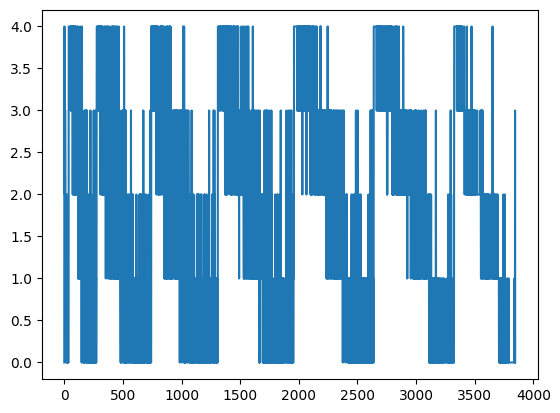

In [76]:
plt.plot(ind_age_t)

### Slower -- but more secure -- method

In [97]:
from tqdm import tqdm

In [98]:
# Create a DataFrame
df = pd.DataFrame({'label': segmask.flatten(),
        'i_age': i_age_t.flatten(),
        'prec': prec.flatten(),
        'longitude': longitude_2D.flatten(),
        'latitude': latitude_2D.flatten(),
        })

#- remove nan labels
df_clean = df.dropna()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # replace all negative precip by zeros
    df_clean['prec'][df_clean['prec'] < 0 ] = 0

#- iterate over labels and store max value
all_labels = np.unique(df_clean.label)
all_labels = np.array(all_labels[~np.isnan(all_labels)],dtype=int)

df_list = []

for label in tqdm(all_labels):
    
    # (sub)frame at label
    df_ilab = df_clean.loc[df_clean.label==label]
    # extract max var
    prec_max = np.max(df_ilab.prec)
    # save line of max
    df_list.append(df_ilab.loc[df_ilab.prec==prec_max])



100%|██████████| 3847/3847 [00:11<00:00, 322.06it/s]


In [99]:
pd.concat(df_list)

,label,i_age,prec,longitude,latitude
12195701,1.0,0,49.589684,114.589828,21.110460
12223348,3.0,4,70.835838,114.550781,21.226345
10886402,4.0,4,8.900284,90.097649,15.625217
10388626,5.0,4,19.147652,85.722649,13.539280
10562594,6.0,3,0.000338,41.347652,14.273220
...,...,...,...,...,...
10266242,16510.0,0,0.000000,345.097626,12.998481
10716038,16512.0,0,0.000008,275.253906,14.891276
14167629,16519.0,0,0.002728,103.027336,29.376953
13358623,16631.0,3,0.154301,181.230453,25.977648


So, previous method yields correct results. The issue is only the memory excess.

# DEBUG issue with assignment in v2.08 (prec_max not stored) 

## Are labels found?

In [8]:
# load functions in script
from computeLifeCycleMappingLagrangian import *

In [9]:
#- load LifeCycleMappingObject

region = 'tropics'
out_dir = os.path.join(DIR_OUT,region,'life_cycle_mapping')
lcm_obj_name = 'lcm_%s.pickle'%toocan_version_str
lcm_path = os.path.join(out_dir,lcm_obj_name)

# load
lcm = pickle.load(open(lcm_path,'rb'))

In [10]:
# geographical parameters
if region == 'tropics':
    lon_slice = slice(0,360)
    lat_slice = slice(-30,30)

In [11]:
# test at specific time
# i_t = 1910
i_t = 14

In [12]:
print("time step #%d"% (i_t))
    
# load data at time step t
date, segmask, prec, longitude_2D, latitude_2D, i_age_t = loadDataAtSlice(i_t,lcm,lon_slice,lat_slice)


time step #14


In [13]:
# compute variables at maximum precipitation in each MCS segmentation mask
df_max = computeMaxVarAtSlice(prec,'prec',segmask, longitude_2D, latitude_2D, i_age_t, i_t)

In [30]:
#- define coordinates
N_ages = 240
    
# define label coordinate
# label_toocan = lcm.labels_toocan
label_toocan = lcm.labels_valid
# define age
age = np.arange(N_ages)*lcm.timestep # in hours


In [31]:
#- Initalize output
ds = initOutputArray(label_toocan,age)


In [32]:
#- Fill output array with toocan characteristics
fillWithTrackingData(ds,label_toocan,lcm)


In [17]:
lcm.toocan_timetable

,Unnamed: 0,label,i_t_min,i_t_max,duration
0,0,NaN,NaN,NaN,NaN
1,1,1.0,8.0,76.0,34.5
2,2,2.0,-1.0,78.0,40.0
3,3,3.0,13.0,119.0,53.5
4,4,4.0,59.0,100.0,21.0
...,...,...,...,...,...
304339,304339,304339.0,1914.0,1917.0,2.0
304340,304340,NaN,NaN,NaN,NaN
304341,304341,NaN,NaN,NaN,NaN
304342,304342,NaN,NaN,NaN,NaN


In [33]:
# vars to assign at location of MCS-wise max precipitation
varnames = ['prec','longitude','latitude']

# assign
assignVarMaxToOutput(ds,varnames,lcm,df_max)

store df data at time index 14
intruder labels (present in df but not in TOOCAN object): [2651.]


In [34]:
len(lcm.labels_valid), len(lcm.labels_toocan)

(287027, 287031)

In [35]:
## ___ DEBUG ____
#- compute indices of ordered valid labels (where to assign prec_max) in labels_valid

df = df_max

print('store df data at time index %d'%(df.attrs['i_t']))

# a = lcm.labels_toocan
a = lcm.labels_valid
b = df['label'].values
print(b.size, len(a))

# show labels that are in df_max but not in lcm.labels_toocan
ind_intruders = np.where(~np.isin(b,a))[0]
label_intruders = b[ind_intruders] # just out of curiosity
if len(label_intruders) > 0:
    print('intruder labels (present in df but not in TOOCAN object):',label_intruders)

# ignore intruder labels (not found in b)
ind_common = np.where(np.isin(b,a))[0]
b = b[ind_common]
df = df.iloc[ind_common]

# get indices of labels at t
ind_lab_t = np.argwhere(np.isin(a, b))[:,0]
print(ind_lab_t.shape)

# get indices of ages at t
ind_age_t = df['i_age'].values
print(ind_age_t.shape)

# create coordinates
coords = np.vstack([ind_lab_t,ind_age_t])
assert len(a) == ds['prec_max'].shape[0], "number of labels differ"
print(coords.shape,ds['prec_max'].shape)
print(np.max(ind_lab_t), np.max(ind_age_t))
flat_indices = np.ravel_multi_index(coords, ds['prec_max'].shape)


store df data at time index 14
2598 287027
intruder labels (present in df but not in TOOCAN object): [2651.]
(2597,)
(2597,)
(2, 2597) (287027, 240)
29019 16


In [92]:
# compute all MCS ages (2D)
MCS_age = lcm.computeAgesFromSegMask(i_t,segmask,metric='age')
print(i_t)
print(np.unique(segmask))
print(np.unique(MCS_age))
# age indices (2D)
i_age_t = np.asarray(MCS_age/lcm.timestep,dtype=int)
np.unique(i_age_t)

1910
[ 2.  6. 29. ... nan nan nan]
[955.5 956.    nan ...   nan   nan   nan]


array([-9223372036854775808,                 1911,                 1912])

In [101]:
# __ DEBUG lcm.computeAgesFromSegMask __

#- step 1. Mask of nans and flatten segmentation mask without nans

# flatten segmask
segmask_1D = segmask.flatten()
# mask of nans
mask_nans_segmask_1D = np.isnan(segmask_1D)
# remove nans
segmask_1D_valid = segmask_1D[~mask_nans_segmask_1D]
print(np.sum(~mask_nans_segmask_1D),segmask_1D_valid.shape)
# print(np.unique(segmask_1D_valid))

#- step 2. Take time metrics at labels ## CAREFUL, indices must be equal to labels in toocan_timetable

# births
print(lcm.toocan_timetable['i_t_min'].take(segmask_1D_valid))
i_t_min_valid = np.array(lcm.toocan_timetable['i_t_min'].take(segmask_1D_valid))

# deaths
i_t_max_valid = np.array(lcm.toocan_timetable['i_t_max'].take(segmask_1D_valid))
# durations
durations_valid = np.array(lcm.toocan_timetable['duration'].take(segmask_1D_valid))

# age
metric_valid = (np.array(i_t-i_t_min_valid,dtype=int))*lcm.timestep

print(np.unique(metric_valid))

292034 (292034,)
17913   -2.0
17913   -2.0
17913   -2.0
17913   -2.0
17913   -2.0
        ... 
20184   -2.0
20184   -2.0
20184   -2.0
20184   -2.0
20184   -2.0
Name: i_t_min, Length: 292034, dtype: float64
[955.5 956. ]


In [161]:
# utime_init_t_all = []

for lab in np.unique(lcm.toocan_timetable.take(segmask_1D_valid).label):
    
    i_MCS = lcm.indexOfLabel(lab)

    MCS = lcm.toocan[i_MCS]
    
    utime_init = getattr(MCS,utime_init_key)
    utime_end = getattr(MCS,utime_end_key)
    utime_init_2 = MCS.clusters.LC_UTC_time[0]
    
    i_t_min = utime2i_t(utime_init,toocan_version=toocan_version)
    i_t_max = utime2i_t(utime_end,toocan_version=toocan_version)
    
    date_init = utime2Datetime(utime_init,toocan_version=toocan_version)
    date_current = utime2Datetime(lcm.relation_table.loc[i_t].UTC,toocan_version='v2.07')
    
    print(int(lab),i_MCS,utime_init,utime_init_2,utime_end,i_t_min,i_t_max,date_init,date_current)
    
    # # store all i_t_min
    # utime_init_t_all.append(utime_init)
    break

2 1 1470013200 1470013200 1470155400 -1 78 2016-08-01T01:00:00.000000 2016-09-09T20:30:00.000000


In [167]:
date_init_t_all = [utime2Datetime(utime_init_t_all[i],toocan_version=toocan_version) for i in range(len(utime_init_t_all))]


In [165]:
toocan_utime_init_all = [getattr(lcm.toocan[i],utime_init_key) for i in range(len(lcm.toocan))]

(array([3765., 4031., 4475., 4121., 4725., 4242., 4016., 3784., 3837.,
        4370., 3897., 4225., 3641., 3486., 3695., 2668., 2166., 2227.,
        2242., 2314., 2207., 2183., 2354., 2538., 2413., 2497., 2486.,
        2493., 2258., 2637., 2448., 2592., 2377., 2416., 2571., 2430.,
        2523., 2414., 2526., 2549., 2395., 2566., 2297., 2526., 2606.,
        2550., 2572., 2759., 2429., 2352., 2688., 2817., 2848., 2734.,
        2990., 2652., 2646., 2799., 2927., 3033., 2754., 2809., 2606.,
        2475., 2891., 2633., 2714., 2738., 2674., 3051., 2813., 2861.,
        2902., 2960., 3140., 2764., 3278., 2827., 2846., 2967., 2784.,
        3075., 2989., 2964., 2835., 2641., 2996., 3019., 2912., 2970.,
        2674., 2740., 2457., 2431., 2906., 2728., 2891., 2862., 2725.,
        2704.]),
 array([1.47001140e+09, 1.47004591e+09, 1.47008041e+09, 1.47011492e+09,
        1.47014942e+09, 1.47018393e+09, 1.47021844e+09, 1.47025294e+09,
        1.47028745e+09, 1.47032195e+09, 1.47035646e+09, 1.

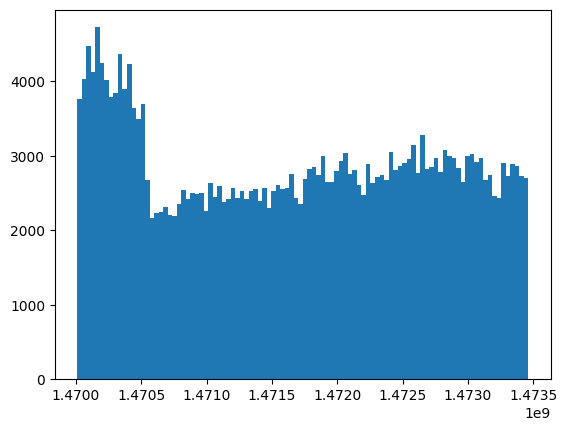

In [147]:
plt.hist(toocan_utime_init_all,bins=100)

In [157]:
utime2Datetime(1.47342749e+09,toocan_version=toocan_version)

numpy.datetime64('2016-09-09T13:24:50.000000')

In [114]:
# __ DEBUG toocan_timetable creation

label_debug = 17913

print(label_debug in segmask)

i_MCS = lcm.indexOfLabel(label_debug)

MCS = lcm.toocan[i_MCS] # ! lcm.

# birth
i_t_min = utime2i_t(getattr(MCS,utime_init_key),toocan_version=toocan_version)
print(getattr(MCS,utime_init_key))
print(utime2Datetime(getattr(MCS,utime_init_key),toocan_version=toocan_version))
print(i_t_min)

True
1470011400
2016-08-01T00:30:00.000000
-2


In [168]:
# ## show range of utime_init (in toocan objects) for all i_t (segmask)

# list_utime_init = []

# for i_t in range(1,1916):
    
    

# Show phasing from online computation (all MCSs)

In [171]:
! ls -lh ../results/tropics/life_cycle_mapping

total 14G
-rw-r--r-- 1 bfildier mesouser 1.4G Feb  8 17:08 lcm.pickle
-rw-r--r-- 1 bfildier mesouser 1.1G Apr  8 16:45 lcm_v208.pickle
-rw-r--r-- 1 bfildier mesouser 1.3G Mar 29 13:39 lifecycle_diag_DYAMOND_Summer_SAM_0.nc
-rw-r--r-- 1 bfildier mesouser 1.3G Mar 29 17:34 lifecycle_diag_DYAMOND_Summer_SAM_1.nc
-rw-r--r-- 1 bfildier mesouser 1.3G Apr  4 11:08 lifecycle_diag_DYAMOND_Summer_SAM_2.nc
-rw-r--r-- 1 bfildier mesouser 1.3G Apr  5 03:09 lifecycle_diag_DYAMOND_Summer_SAM_3.nc
-rw-r--r-- 1 bfildier mesouser 2.6G Apr  8 18:20 lifecycle_diag_DYAMOND_Summer_SAM_v208_0.nc
-rw-r--r-- 1 bfildier mesouser 2.6G Apr  8 20:36 lifecycle_diag_DYAMOND_Summer_SAM_v208_1.nc
drwxr-xr-x 2 bfildier mesouser  102 Mar 29 09:46 tests


In [172]:
# filepath = os.path.join(DIR_OUT,'tropics','life_cycle_mapping','lcm.pickle')
# filepath = os.path.join(DIR_OUT,'tropics','life_cycle_mapping','lifecycle_diag_DYAMOND_Summer_SAM_3.nc')
filepath = os.path.join(DIR_OUT,'tropics','life_cycle_mapping','lifecycle_diag_DYAMOND_Summer_SAM_v208_1.nc')

In [173]:
lcm_data = xr.open_dataset(filepath)

In [174]:
lcm_data

<xarray.Dataset>
Dimensions:        (MCS_label: 287031, age: 240)
Coordinates:
  * MCS_label      (MCS_label) int64 1 2 3 4 5 ... 304337 304338 304339 304343
  * age            (age) float64 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5
Data variables:
    valid_flag     (MCS_label) bool ...
    area           (MCS_label, age) float64 ...
    time_birth     (MCS_label) datetime64[ns] ...
    time_death     (MCS_label) datetime64[ns] ...
    duration       (MCS_label) float64 ...
    prec_max       (MCS_label, age) float64 ...
    longitude_max  (MCS_label, age) float64 ...
    latitude_max   (MCS_label, age) float64 ...
    land_mask      (MCS_label, age) float64 ...
Attributes:
    description:  Lagrangian MCS data

In [175]:
lcm_data.prec_max[:,0]

<xarray.DataArray 'prec_max' (MCS_label: 287031)>
[287031 values with dtype=float64]
Coordinates:
  * MCS_label  (MCS_label) int64 1 2 3 4 5 ... 304337 304338 304339 304343
    age        float64 0.0

In [176]:
np.sum(np.isnan(lcm_data.prec_max))/(np.prod(lcm_data.prec_max.shape))

<xarray.DataArray 'prec_max' ()>
array(0.99982752)

In [13]:
# Compute MCS label with valid precipitation lifecycle (at least one element)

i_0 = 90

prec_max_0 = lcm_data.prec_max[:,i_0]
mask_valid_prec = ~np.isnan(prec_max_0)
prec_valid_prec = prec_max_0[mask_valid_prec]
labels_valid_prec = lcm_data.MCS_label[mask_valid_prec]
labels_valid_prec

<xarray.DataArray 'MCS_label' (MCS_label: 0)>
array([], dtype=int64)
Coordinates:
  * MCS_label  (MCS_label) int64 
    age        float64 45.0
Attributes:
    description:  TOOCAN labels for non-duplicate MCS labels only
    units:        None

In [13]:
### DEBUG 

# TEST wether the values are correctly assigned in the output file 

# example : MCS label 1

lcm_data.sel(MCS_label=5)



<xarray.Dataset>
Dimensions:        (age: 96)
Coordinates:
    MCS_label      int64 5
  * age            (age) float64 0.0 0.5 1.0 1.5 2.0 ... 46.0 46.5 47.0 47.5
Data variables:
    valid_flag     bool ...
    area           (age) float64 ...
    time_birth     datetime64[ns] ...
    time_death     datetime64[ns] ...
    duration       float64 ...
    prec_max       (age) float64 ...
    longitude_max  (age) float64 ...
    latitude_max   (age) float64 ...
    land_mask      (age) float64 ...
Attributes:
    description:  Lagrangian MCS data

In [15]:
labels_valid_prec.values

array([], dtype=int64)

In [14]:
# A few examples of precipitation evolution along individual lifecycles

labels_rand = np.random.choice(labels_valid_prec.values,16)

# label = labels_valid_prec[0].values

fig,axs = plt.subplots(4,4,figsize=(11,10))

for label,i_ax in zip(labels_rand,range(16)):

    print(label,end=' ')

    x = lcm_data.sel(MCS_label=label).age
    y = lcm_data.sel(MCS_label=label).prec_max
    d = lcm_data.sel(MCS_label=label).duration
    a = lcm_data.sel(MCS_label=label).area

    ax = axs.flatten()[i_ax]
    
    # prec_max
    ax.plot(x,y)
    # duration
    ax.axvline(x=d,c='k',linestyle='--')
    # anvil area
    ax_a = ax.twinx()
    ax_a.plot(x,a,c='grey')
    ax_a.set_ylim(-100,1e4)
    
    if i_ax > 11:
        ax.set_xlabel('age (hrs)')
    if i_ax%4 == 0:
        ax.set_ylabel('Prec_max (mm/day)')
    if i_ax%4 != 3:
        ax_a.set_visible(False)
    ax.set_title('label %d'%label)

ValueError: 'a' cannot be empty unless no samples are taken

In [30]:
durations_valid_prec = lcm_data.duration.loc[mask_valid_prec]

In [31]:
# coord number
N_labels = lcm_data.MCS_label.size
N_ages = lcm_data.age.size
# define matrix of ages as stored in database
age_2D = np.repeat(lcm_data.age.data[np.newaxis,:],N_labels,axis=0)
# mask nans after MCS death
mask_dead = np.isnan(lcm_data.area)
age_2D[mask_dead] = np.nan
# define matrix of durations ages as stored in database
durations_2D = np.repeat(lcm_data.duration.data[:,np.newaxis],N_ages,axis=1)
# define matrix of normalized ages as stored in database
norm_age_2D = age_2D/durations_2D


In [32]:
#-- Distribution of durations

dist_duration = Distribution()
dist_duration.defineLinearBins(lcm_data.duration.values,vmin=0,vmax=48)
dist_duration.computeDistribution(lcm_data.duration.values)


In [33]:
def createMergedLegend(ax1,ax2,loc='upper left'):
    
    # Getting both lines and labels for legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Concatenating lines and labels
    lines = lines1 + lines2
    labels = labels1 + labels2

    # Drawing legend
    ax1.legend(lines, labels, loc=loc)

<xarray.DataArray 'age' ()>
array(40.)
Coordinates:
    age      float64 40.0
Attributes:
    description:  age coordinate for anvil lifecycle
    units:        hours from time of birth


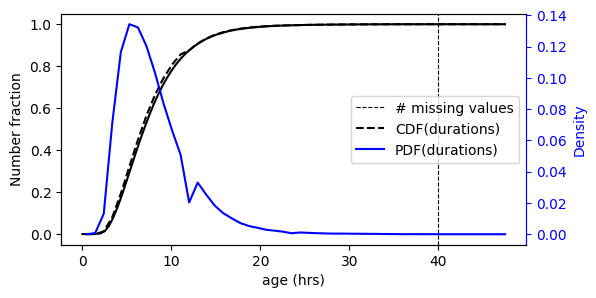

In [34]:
n_nans_vs_age = np.sum(np.isnan(age_2D),axis=0)/age_2D.shape[0]

fig,ax = plt.subplots(figsize=(6,3))

#- n(nans)
ax.plot(lcm_data.age,n_nans_vs_age,c='k')

# first age index without data
i_all = np.where(n_nans_vs_age == 1)[0][0]
print(lcm_data.age[i_all])
ax.axvline(x=lcm_data.age[i_all],c='k',linestyle='--',linewidth=0.8,label='# missing values')

ax.set_xlabel('age (hrs)')
ax.set_ylabel('Number fraction')

#- durations
ax2 = ax.twinx()

ax2.plot(dist_duration.percentiles,dist_duration.density,c='b',label='PDF(durations)')

col = 'b'
ax2.set_ylabel('Density')
ax2.spines['right'].set_color(col)
ax2.yaxis.label.set_color(col)
ax2.tick_params(axis='y', colors=col)

# cumulative sum
ax.plot(dist_duration.percentiles,np.cumsum(dist_duration.density)/np.cumsum(dist_duration.density)[-1],c='k',linestyle='--',label='CDF(durations)')

# legend
createMergedLegend(ax,ax2,loc='center right')

plt.show()

In [37]:
print('Space occupied by nans: %2.1f%%'%(np.sum(np.isnan(norm_age_1D))/norm_age_1D.size*100))

Space occupied by nans: 83.4%


In [36]:
#-- Compute conditional mean prec_max on normalized MCS age

# flatten arrays
norm_age_1D = norm_age_2D.flatten()
prec_max_1D = lcm_data.prec_max.data.flatten()

#-- use distribution class to compure reference distribution of ages
# initialize
dist_normage_lin = Distribution(name='normage',nbins=30)
# compute distribution
dist_normage_lin.computeDistribution(sample=norm_age_1D,vmin=0,vmax=1)
# compute locations of bins
dist_normage_lin.storeBinLocations(sample=norm_age_1D,sizemax=100)

#-- test ConditionalDistribution class for norm_age conditioned on itself
cdist_normage_on_normage = ConditionalDistribution(name='norm_age_on_norm_age',
                                                   is3D=False,
                                                   on=dist_normage_lin)
cdist_normage_on_normage.computeConditionalMeanAndVariance(norm_age_1D)

#-- use ConditionalDistribution class to map prec_max onto 
cdist_precmax_on_normage = ConditionalDistribution(name='prec_max_on_norm_age',
                                                   is3D=False,
                                                   on=dist_normage_lin)
cdist_precmax_on_normage.computeConditionalMeanAndVariance(prec_max_1D)

/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:1086: RuntimeWarning: Mean of empty slice
  out[i_b] = fun(subsample)
/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:1086: RuntimeWarning: Degrees of freedom <= 0 for slice.
  out[i_b] = fun(subsample)


In [26]:
dist_normage_lin

< Distribution object:
 . bintype: linear
 . nbins: 30
 . nbpd: None
 . nppb: None
 . nd: None
 . fill_last_decade: None
 . name: normage
 . size: 33322176
 . vmin: 0
 . vmax: 1
 . rank_edges: None
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: <class 'numpy.ndarray'>
 . bin_locations_stored: True
 . overwrite: False
 . frac_below_vmin: 0.0
 . frac_above_vmax: 0.0
 . bin_locations: <class 'list'>
 . bin_sample_size: <class 'list'>
 >

Text(0, 0.5, 'Density')

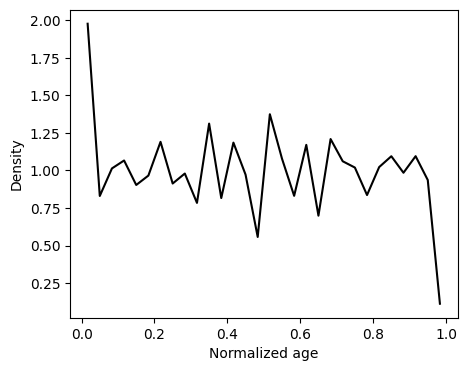

In [27]:
# Distribution of normalized ages
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(dist_normage_lin.percentiles,dist_normage_lin.density,'k')

ax.set_xlabel('Normalized age')
ax.set_ylabel('Density')

In [57]:
# MCS-maximum precipitation vs. MCS duration

max_MCS_prec = np.nanmax(lcm_data.prec_max.values,axis=1)
print('Number of MCS where max prec is all nans: %2.1f%%'%(np.sum(np.isnan(max_MCS_prec))/max_MCS_prec.size*100))


Number of MCS where max prec is all nans: 96.7%


/tmp/ipykernel_3328196/1925373275.py:3: RuntimeWarning: All-NaN slice encountered
  max_MCS_prec = np.nanmax(lcm_data.prec_max.values,axis=1)


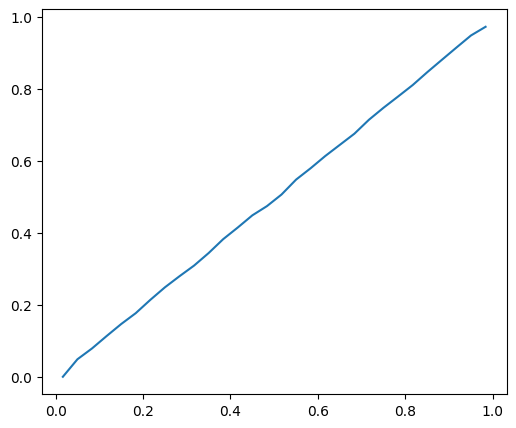

In [58]:
# norm_age conditioned on norm_age --- OK

fig,ax = plt.subplots(figsize=(6,5))

y = cdist_normage_on_normage.cond_mean
x = dist_normage_lin.percentiles

ax.plot(x,y)

In [59]:
cdist_precmax_on_normage

< ConditionalDistribution object:
 . name: prec_max_on_norm_age
 . is3D: False
 . isTime: False
 . on: <class 'conditionalstats.Distribution'>
 . mean: None
 . cond_mean: <class 'numpy.ndarray'>
 . cond_var: <class 'numpy.ndarray'>
 . cond_std: <class 'numpy.ndarray'>
 >

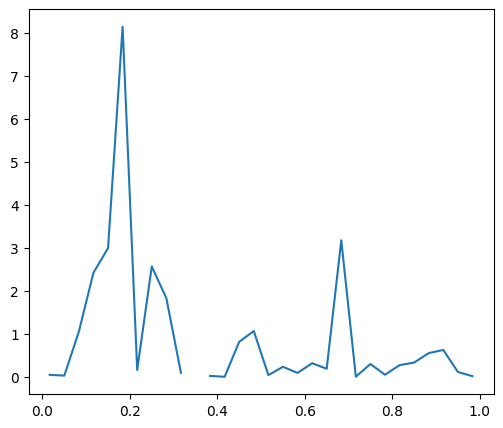

In [60]:
# prec_max conditioned on norm_age

fig,ax = plt.subplots(figsize=(6,5))

x = dist_normage_lin.percentiles
y = cdist_precmax_on_normage.cond_mean


ax.plot(x,y)

In [61]:
#-- Sanity check (1. --#
#
# check all MCS 'age' length is equation to their stored duration
#

n_ages_MCS = np.array([np.sum(~np.isnan(lcm_data.area),axis=1)])[0]
print(n_ages_MCS[:10])
print(lcm_data.duration[:10]*2)
diff_durations = np.where(n_ages_MCS != lcm_data.duration*2)
print(n_ages_MCS[diff_durations])
print(lcm_data.duration[diff_durations]*2)
print()
print('ok')

#
#----------------------#

[25 32 76 21 25 14 15 33 30 75]
<xarray.DataArray 'duration' (MCS_label: 10)>
array([25., 32., 76., 21., 25., 14., 15., 33., 30., 75.])
Coordinates:
  * MCS_label  (MCS_label) int64 287370 287371 287372 ... 287378 287379 287380
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
<xarray.DataArray 'duration' (MCS_label: 272)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, n